[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 20ms/step


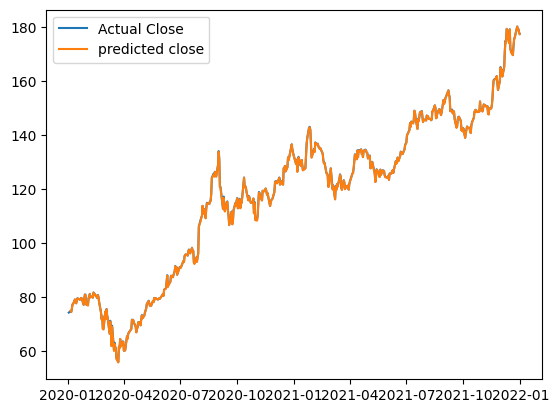

In [3]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import yfinance as yf
import matplotlib.pyplot as plt

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Download and preprocess Apple stock market data
start_date = '2020-01-01'
end_date = '2022-01-01'
ticker = 'AAPL'

df = yf.download(ticker, start=start_date, end=end_date)
df = df.dropna()
df['Returns'] = df['Close'].pct_change()
df = df.iloc[1:]
observations = len(df)

# Define neural networks for Q and Policy functions
state_shape = 1
action_shape = 1
q_model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(state_shape + action_shape,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])
policy_model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(state_shape,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(action_shape, activation='tanh')
])

# Define DDPG hyperparameters
gamma = 0.99
tau = 0.001
buffer_size = 100000
batch_size = 6400

# Define DDPG algorithm
replay_buffer = []
policy_optimizer = optimizers.Adam(learning_rate=0.001)
#q_optimizer = optimizers.Adam(learning_rate=0.001)

def ddpg(state, action, reward, next_state, done):
    # Add the transition to the replay buffer
    replay_buffer.append((state, action, reward, next_state, done))

    # Sample a batch of transitions from the replay buffer
    if len(replay_buffer) < batch_size:
        return
    batch = random.sample(replay_buffer, batch_size)
    states = np.array([transition[0] for transition in batch])
    actions = np.array([transition[1] for transition in batch])
    rewards = np.array([transition[2] for transition in batch])
    next_states = np.array([transition[3] for transition in batch])
    dones = np.array([transition[4] for transition in batch])

    # Update the Q function
    next_actions = policy_model.predict(next_states)

    q_values_next = q_model.predict(np.concatenate([next_states, next_actions], axis=-1))

    q_targets = rewards + gamma * q_values_next * (1 - dones)

    # Q_value: Q(s, a) = E[R_t+1 + gamma * max(Q(s', a'))]

    q_loss = q_model.train_on_batch(np.concatenate([states, actions], axis=-1), q_targets)

    # Update the Policy function
    with tf.GradientTape() as tape:

        actions = policy_model(states)

        q_values = q_model(tf.concat([states, actions], axis=-1))

        policy_loss = -tf.reduce_mean(q_values)

        # cost Q-function:

        #(1 / (batch_size * num_actions)) * sum(q_values)



    policy_grads = tape.gradient(policy_loss, policy_model.trainable_variables)

    policy_optimizer.apply_gradients(zip(policy_grads, policy_model.trainable_variables))

    # Update the target Q and Policy functions
    new_weights = []

    target_variables = q_model.weights + policy_model.weights

    for i, variable in enumerate(target_variables):
        new_weights.append(tau * variable + (1 - tau) * variable)

    q_model.set_weights(new_weights[:len(q_model.weights)])

    policy_model.set_weights(new_weights[len(q_model.weights):])

# Train the DDPG algorithm
state = np.array([[df['Returns'][0]]])

for i in range(1, observations):

    # Calculate the signal for buying or selling
    last_period_close = df['Close'][i-1]

    today_close = df['Close'][i]

    predicted_close = today_close*(1+policy_model.predict(state)[0][0])
    # Calculate the predicted close price
    predicted_close = today_close*(1+policy_model.predict(state)[0][0])

    # Add the predicted close price to the dataframe
    df.loc[df.index[i], 'predicted_close'] = predicted_close

    signal=0

    if predicted_close > last_period_close:
        signal = 1
    elif predicted_close < last_period_close:
        signal = -1


    # Calculate the reward for the previous action
    reward = signal * df['Returns'][i]

    # Update the state and take a new action
    next_state = np.array([[df['Returns'][i]]])

    action = np.array([[signal]])
    ########################################################

    ddpg(state, action, reward, next_state, False)

    state = next_state
plt.plot(df['Close'], label='Actual Close')
plt.plot(df['predicted_close'], label='predicted close')
plt.legend()
plt.show()

